# Synopsis

This code generates the g2 (ROI2) and tau vs. Q figure (water) for the manuscript

## Initialize

In [1]:

import numpy as np
from numpy import sqrt, sin, cos, pi, exp
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import h5py  
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from xpcs_viewer import XpcsFile as xf


## Read data

In [2]:

fn_path = '../Reduced_Data/'
Water = xf('J058_Water_XPCS_Trim.hdf', cwd = fn_path)


## Fit g2 for water data

In [3]:

contrast = 0.14
exp_arg = 1

LB_list_g2 = [contrast, 1e-6, exp_arg, 0.95]
UB_list_g2 = [contrast, 1, exp_arg, 1.05]

_ = Water.fit_g2(q_range=[0, 0.01],t_range=[1e-8, 1e1], bounds=[LB_list_g2,UB_list_g2],
    fit_flag=[False, True, False, True])

g2_fit_line_Water = _["fit_line"]
# g2_fit_line stores fitted g2 at different q's into a list of dictionaries. 
# Each dictionary contains two keys, fit_x and fit_y.
# fit_x is a 2D numpy array that corresponds to the time axis at that q;
# fit_y is a 2D numpy array that corresponds to the fitted g2 values at that q;

# g2_fit_coeff is a 3D numpy array.
# i is the q ROI index;
# j=0 for fit values, j=1 for errors;
# k=0,1,2,3 to select fitting parameters
g2_fit_coeff_Water = _["fit_val"]

tauq_power = -2
LB_list_tauQ = [1e-12, tauq_power]
UB_list_tauQ = [1e-3, tauq_power]

_ = Water.fit_tauq(q_range=[0, 0.01], bounds=[LB_list_tauQ, UB_list_tauQ], fit_flag=[True, False])
tauq_fit_val_Water = _["tauq_fit_val"]
tauq_fit_line_Water = _["tauq_fit_line"]
tauq_q_Water = _["tauq_q"]
tauq_tau_Water = _["tauq_tau"]
tauq_tau_err_Water = _["tauq_tau_err"]


## Plotting g2 vs. tau and tau vs. Q (inset)

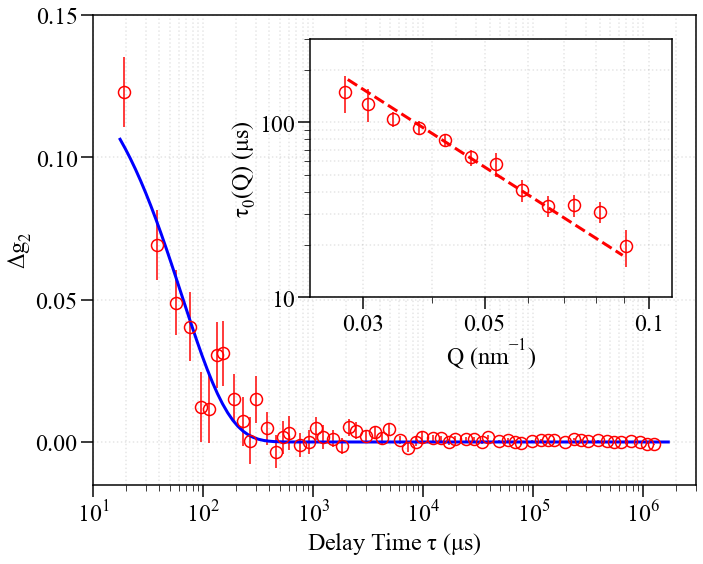

In [5]:


# Use scale=1 for production figure and scale=3 for viewing in Jupyter Notebook
scale = 3

width = 3.6*scale
font_size = 8*scale
line_width = 0.5*scale
marker_size = 4*scale
tick_length_major = 4*scale
tick_length_minor = 2*scale

dim=1

###### Set up canvas ######
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(width, 0.8*width))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.linewidth'] = line_width

###### Plot g2 ######
ax.errorbar(Water.t_el[:-1], Water.g2[:-1,dim]-g2_fit_coeff_Water[dim,0,3], yerr=Water.g2_err[:-1,dim], 
            fmt='ro', markersize=marker_size, linewidth=line_width, markeredgewidth=line_width,
            markerfacecolor='none')
ax.plot(g2_fit_line_Water[dim]["fit_x"][10:-10], g2_fit_line_Water[dim]["fit_y"][10:-10] \
        -g2_fit_coeff_Water[dim,0,3], 'b-', linewidth=2*line_width)

###### Set up ticks, labels and strokes ######
ax.grid(color='k', linestyle=':', linewidth=line_width, alpha=0.1, which='both')
ax.tick_params('both', length=tick_length_major, width=line_width, which='major', labelsize=font_size)
ax.tick_params('x', length=tick_length_minor, width=0.5*line_width, which='minor',
              labelleft=False, labelbottom=False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(line_width)

ax.set_xscale('log')
ax.set_xlim(1e-5, 3)
ax.set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0])
ax.set_xticklabels(['10$^\mathdefault{1}$',
                    '10$^\mathdefault{2}$',
                    '10$^\mathdefault{3}$',
                    '10$^\mathdefault{4}$',
                    '10$^\mathdefault{5}$',
                    '10$^\mathdefault{6}$'],
                    fontsize = font_size)
ax.set_xlabel('Delay Time $\mathdefault{\u03C4}$ ($\mathdefault{\mu}$s)', 
              fontsize=font_size, labelpad=0.2*font_size)

ax.set_yticks([0,0.05,0.1,0.15])
ax.set_ylim(-0.015, 0.15)
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_ylabel('$\mathdefault{\Delta}$g$\mathdefault{_2}$', 
              fontsize=font_size, labelpad=0.05*font_size)

###### Plot inset (tau vs. Q) ######
axins = inset_axes(ax, width="60%", height="55%", loc=1, borderpad=0.1*font_size)
axins.errorbar(tauq_q_Water, tauq_tau_Water, tauq_tau_err_Water, fmt='ro', markeredgewidth=line_width,
               linewidth=line_width, markersize=marker_size, markerfacecolor='none')
axins.plot(tauq_fit_line_Water["fit_x"][10:-10], tauq_fit_line_Water["fit_y"][10:-10], 'r--', 
           linewidth=2*line_width)
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(line_width)

###### Set up ticks, labels and strokes for the inset ######
axins.grid(color='k', linestyle=':', linewidth=line_width, alpha=0.1, which='both')
axins.tick_params('both', length=tick_length_major, width=line_width, which='major', labelsize=font_size)
axins.tick_params('both', length=tick_length_minor, width=0.5*line_width, which='minor', 
               labelleft=False, labelbottom=False)

axins.set_xscale('log')
axins.set_xlim(2.4e-3, 1.1e-2)
axins.set_xticks([3e-3, 5e-3, 1e-2])
axins.set_xticklabels([0.03, 0.05, 0.1], fontsize=font_size)
axins.set_xlabel('Q (nm$\mathdefault{^{-1}}$)', fontsize=font_size, labelpad=0.05*font_size)

axins.set_yscale('log')
axins.set_ylim(1e-5, 3e-4)
axins.set_yticks([1e-5, 1e-4])
axins.set_yticklabels([10, 100], fontsize=font_size)
axins.set_ylabel('$\mathdefault{\u03C4_0}$(Q) ($\mathdefault{\mu}$s)', 
              fontsize=font_size, labelpad=0.05*font_size)

# axins.set_xscale('log')
# axins.set_xticks([3e-3, 4e-3, 5e-3])
# axins.set_xticklabels([0.03, 0.04, 0.05], fontsize=font_size)
# axins.set_xlabel('Q (nm$\mathdefault{^{-1}}$)', fontsize=font_size, labelpad=0.05*font_size)

# axins.set_ylim(1e-5, 2e-4)
# axins.set_yscale('log')
# axins.set_yticks([5e-5, 1e-4, 2e-4])
# axins.set_yticklabels([50, 100, 200], fontsize=font_size)
# axins.set_ylabel('$\mathdefault{\u03C4_0}$ ($\mathdefault{\mu}$s)', fontsize=font_size,
#                 labelpad=0.05*font_size)

###### Save image ######
plt.savefig('g2_tauQ_Water.pdf', dpi=600, format='pdf', 
            facecolor='w', edgecolor='w', transparent=False, bbox_inches='tight')
